# Import stuff

To run the code below, you'll need to `pip install` the following packages into
a conda environment:

- `freud-analysis`
- `trackpy`
- `tables`
- `git+https://github.com/ianrgraham/schmeud@master`: Don't install this yet.
  The code below doesn't yet need it.
- `ipykernel`

In [53]:
import numpy as np
import freud
import schmeud
# This module is an extension library, calling directly into high performance code
from schmeud import _schmeud as schmeud_rs
import trackpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as collections
import matplotlib.cm as cm
import matplotlib.colors as colors

# Code

In [2]:
# Let's grab two frames from the experiment

# Change these to whatever works on your machine
path_to_tracks = "/media/ian/Data2/monk/isr/3_Freq0.1_Amp0.2/tracks.h5"
path_to_needle = "/media/ian/Data2/monk/isr/3_Freq0.1_Amp0.2/toolpos_new.h5"

hdf_store = trackpy.PandasHDFStore(path_to_tracks, "r")
needle_df = pd.read_hdf(path_to_needle)

<Axes: title={'center': 'Needle position'}, xlabel='frame', ylabel='y'>

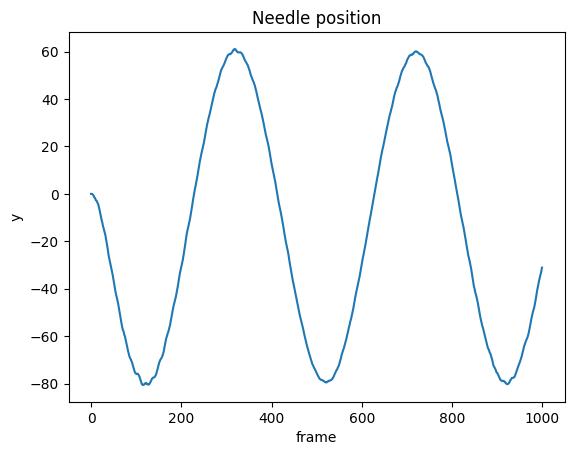

In [3]:
needle_df.iloc[:1000].plot(ylabel="y", xlabel="frame", title="Needle position")

In [18]:
# Let's use frames 400 and 425 for this test, since they have a decent amount
# of relative strain between them

initial = hdf_store[400]
final = hdf_store[425]

def trim_data_inplace(df: pd.DataFrame):
    """drop all data but positions and particle id"""
    df.drop('frame', inplace=True, axis=1)
    df.drop('ep', inplace=True, axis=1)
    df.drop('ecc', inplace=True, axis=1)
    df.drop('mass', inplace=True, axis=1)
    df.drop('size', inplace=True, axis=1)
    df.drop('signal', inplace=True, axis=1)
    # by assigning the index to the particle id, we can easily join the two dataframes
    df.index = df["particle"].astype(np.uint32)  # not sure why Nathan saved this as a float32, let's change it
    df.index.name = "id"
    df.drop('particle', inplace=True, axis=1)

trim_data_inplace(initial)
trim_data_inplace(final)
final.rename(columns={"x": "x_final", "y": "y_final"}, inplace=True)

In [19]:
data = initial.join(final, on="id")
data.dropna(inplace=True)

In [20]:
data.head()

,x,y,x_final,y_final
id,,,,
0,1427.894653,201.606033,1406.848877,201.747467
1,1953.777466,250.430115,1934.416870,250.673477
2,1573.602417,714.218384,1566.017700,714.160461
4,427.551147,255.295227,408.012024,255.647369
5,1926.317017,244.811111,1906.757935,245.313568


In [34]:
init_pos = np.pad(data.iloc[:, 0:2].values, ((0, 0), (0, 1)), 'constant', constant_values=0)
mean_vals = np.mean(init_pos, axis=0)
init_pos -= mean_vals
final_pos = np.pad(data.iloc[:, 2:4].values, ((0, 0), (0, 1)), 'constant', constant_values=0) - mean_vals

In [35]:
l = np.max(init_pos) * 4
box = freud.box.Box.square(l)

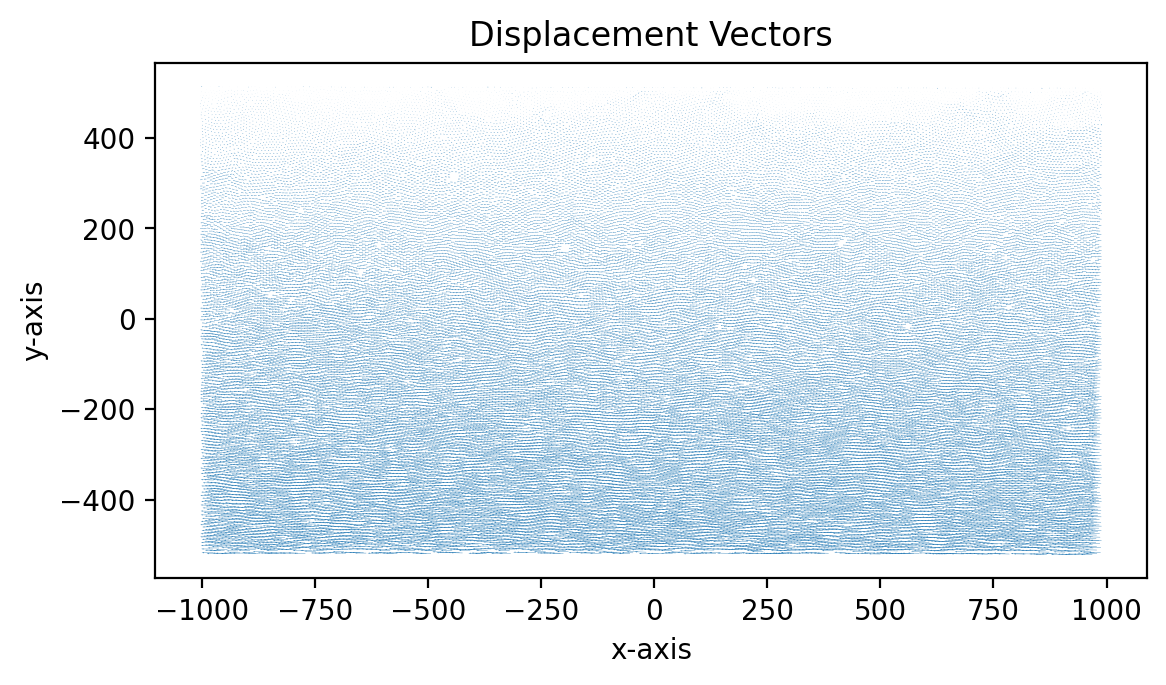

In [36]:
# matplotlib show line patches of displacement vectors

def plot_displacement_vectors(start_points, displacements):
    fig, ax = plt.subplots(dpi=200)
    ax.set_aspect('equal')  # To ensure that the plot is not distorted.

    arrows = [patches.Arrow(start[0], start[1], disp[0], disp[1], width=4) 
              for start, disp in zip(start_points, displacements)]

    collection = collections.PatchCollection(arrows, match_original=True)
    ax.add_collection(collection)

    # Adjust the plot limits if necessary to include all vectors.
    ax.autoscale_view()

    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Displacement Vectors')
    plt.show()

plot_displacement_vectors(init_pos, final_pos - init_pos)

In [40]:
def compute_neighbors(box, pos, nquery=None):

    if nquery is None:
        nquery = {'num_neighbors': 20, 'exclude_ii': True}

    nlist_query = freud.locality.AABBQuery(box, pos)
    nlist = nlist_query.query(pos, nquery).toNeighborList()

    return nlist

In [57]:
# The D2min calculation, leveraging existing linear algebra libraries, isn't
# very complicated

def d2min_py(u, v):
    """Calculates D2min for a set of bonds
    
    Args
        u: initial bond vectors (NxD array)
        v: final bond vectors (NxD array)
    """

    from numpy.linalg import inv

    V = u.transpose().dot(u)
    W = u.transpose().dot(v)
    J = inv(V).dot(W)  # J is the affine transformation matrix
    non_affine = u.dot(J) - v
    d2min = np.sum(np.square(non_affine))
    return d2min


def d2min_system(init_pos, final_pos, nlist):
    
    result = np.zeros(len(init_pos))

    for idx, (segment, counts) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
        # print(idx)
        jdxs = nlist.point_indices[segment:segment + counts]
        u = init_pos[jdxs,:2] - init_pos[idx,:2]
        v = final_pos[jdxs,:2] - final_pos[idx,:2]
        # print(u, v)
        d2min = d2min_py(u, v)
        result[idx] = d2min

    return result

In [58]:
nlist = compute_neighbors(box, init_pos)
d2min = d2min_system(init_pos, final_pos, nlist)

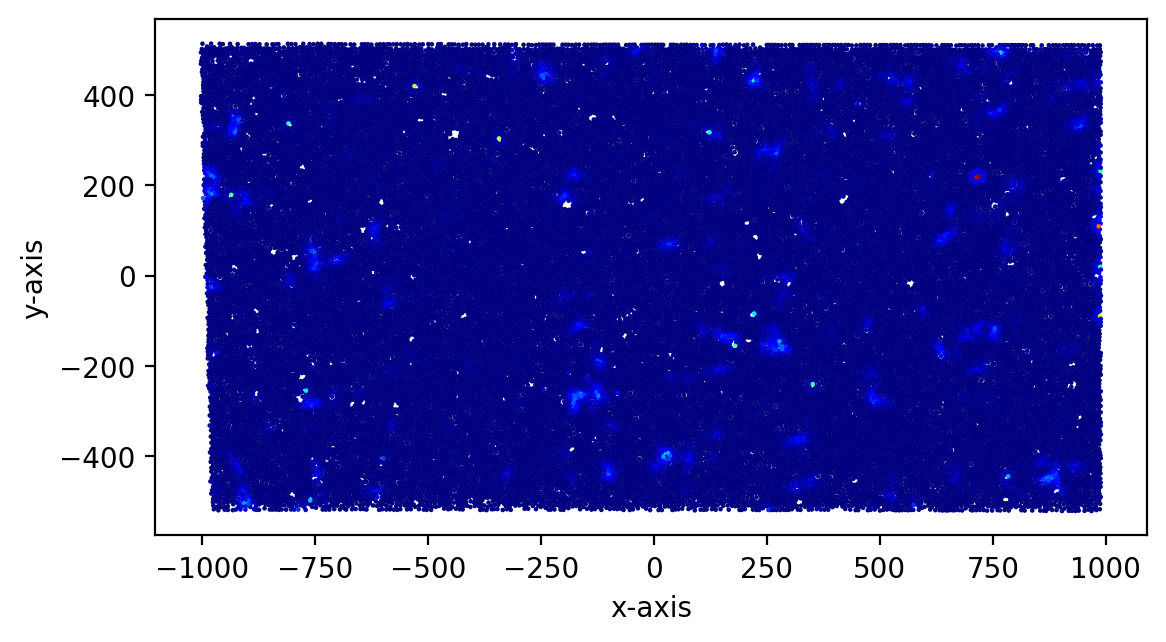

In [61]:
def plot_scalar_field(pos, field, log=False):
    fig, ax = plt.subplots(dpi=200)
    ax.set_aspect('equal')  # To ensure that the plot is not distorted.

    cmap = cm.jet
    if log:
        min = np.min(field[field > 0])
        norm = colors.LogNorm(vmin=min, vmax=field.max())
    else:
        norm = colors.Normalize(vmin=field.min(), vmax=field.max())

    arrows = [patches.Circle(p, radius=2, color=cmap(norm(s))) 
              for p, s in zip(pos, field)]

    collection = collections.PatchCollection(arrows, match_original=True)
    ax.add_collection(collection)

    # Adjust the plot limits if necessary to include all vectors.
    ax.autoscale_view()

    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

plot_scalar_field(init_pos, d2min)

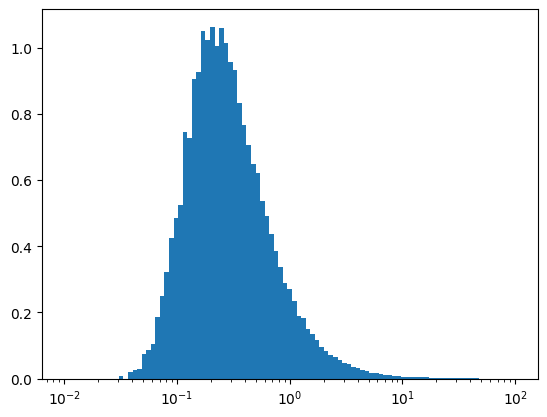

In [70]:
plt.hist(d2min, bins=np.geomspace(1e-2, 1e2, 100), density=True)
plt.xscale('log')

In [60]:
# But we need faster! Using the same data, call into schmeud to compute d2min
 
# I'm making some updates to the schmeud library so you'll be able to install
# it from pip.

